# guiding question:

What if we just used the forward model to get exchange between substrate pools and calculate the probabilities based on the proportions of substrate? Like what's the probability of getting a 15NH2OH and a 15NO? Then we can add these to get the total production of 46N2O that we would expect from that combination of processes — and likewise for each of the other isotopomers as well.

# next:

- separate out rate constants for different steps in AOA ammonia oxidation pathway
- which version of the model best explains the data?

# initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# use for initialization
from collections import namedtuple

# use for plotting interpolations of measured incubation data
import scipy.interpolate as interp

# use for nelder-mead optimization of a convex function
from scipy.optimize import minimize
from numpy.random import rand

import scripts as sc # Python scripts containing helper functions

Set up the model:

In [95]:
### READ IN TRAINING DATA ###
path_to_data = sc.datapath()
filename = '00_incubationdata.csv'

PS2SCM15NO2 = sc.grid_data(filename=f'{path_to_data}{filename}',
                          station="PS2", feature="SCM", tracer="NO2-", 
                          T=1000)

### SUBSTRATE CONCENTRATIONS AND RATES OF EXCHANGE ###
bgc = sc.BioGeoChemistry("PS2SCM", tracer="NO2-")

### ISOTOPE EFFECTS ###
isos = sc.IsotopeEffects()

### MODEL PARAMS ###
modelparams = sc.modelparams()

### STATE VARIABLES ###
tr = sc.Tracers(bgc, PS2SCM15NO2) 

### INITIAL GUESS FOR OPTIMIZATION ###
x = sc.kestimates(bgc,
                  inputdata=pd.read_csv(f'{sc.datapath()}00_incubationdata.csv'),
                  station="PS2", feature="SCM", hybridtracer="NO2-") 

[kestimateNH4, kestimateNO2, kestimateNO3, kestimatehybrid] = x

In [118]:
### READ IN TRAINING DATA ###
path_to_data = sc.datapath()
filename = '00_incubationdata.csv'

PS2SCM15NO3 = sc.grid_data(filename=f'{path_to_data}{filename}',
                          station="PS2", feature="SCM", tracer="NO3-", 
                          T=1000)

### SUBSTRATE CONCENTRATIONS AND RATES OF EXCHANGE ###
bgc = sc.BioGeoChemistry("PS2SCM", tracer="NO3-")

### ISOTOPE EFFECTS ###
isos = sc.IsotopeEffects()

### MODEL PARAMS ###
(dt, T, times) = sc.modelparams()

### STATE VARIABLES ###
tr = sc.Tracers(bgc, PS2SCM15NO3)

### INITIAL GUESS FOR OPTIMIZATION ###
x = sc.kestimates(bgc,
                  inputdata=pd.read_csv(f'{sc.datapath()}00_incubationdata.csv'),
                  station="PS2", feature="SCM", hybridtracer="NO2-") 

[kestimateNH4, kestimateNO2, kestimateNO3, kestimatehybrid] = x

In [60]:
### READ IN TRAINING DATA ###
path_to_data = sc.datapath()
filename = '00_incubationdata.csv'

PS2SCM15NH4 = sc.grid_data(filename=f'{path_to_data}{filename}',
                          station="PS2", feature="SCM", tracer="NH4+", 
                          T=1000)

### SUBSTRATE CONCENTRATIONS AND RATES OF EXCHANGE ###
bgc = sc.BioGeoChemistry("PS2SCM", tracer="NH4+")

### ISOTOPE EFFECTS ###
isos = sc.IsotopeEffects()

### MODEL PARAMS ###
(dt, T, times) = sc.modelparams()

### STATE VARIABLES ###
tr = sc.Tracers(bgc, PS2SCM15NH4)

### INITIAL GUESS FOR OPTIMIZATION ###
x = sc.kestimates(bgc,
                  inputdata=pd.read_csv(f'{sc.datapath()}00_incubationdata.csv'),
                  station="PS2", feature="SCM", hybridtracer="NH4+") 

[kestimateNH4, kestimateNO2, kestimateNO3, kestimatehybrid] = x

# model setup

In [61]:
# no intermediates
def modelv1(x, bgc, isos, tracers, modelparams):

    ### UNPACK X ###
    [knitrification, kdenitno2, kdenitno3, khybrid1, khybrid2] = x
    
    ### UNPACK MODEL PARAMS ###
    (dt, T, times) = modelparams

    ### TIME STEPPING ###
    for iT in range(T-1):

        Jhybrid1 = khybrid1*(tracers.nh4_14[iT]+tracers.nh4_15[iT])*(tracers.no2_14[iT]+tracers.no2_15[iT])
        Jhybrid2 = khybrid2*(tracers.nh4_14[iT]+tracers.nh4_15[iT])*(tracers.no2_14[iT]+tracers.no2_15[iT])

        Jnitrification = knitrification*((tracers.nh4_14[iT]+tracers.nh4_15[iT])**2)
        Jdenitno2 = kdenitno2*((tracers.no2_14[iT]+tracers.no2_15[iT])**2)
        Jdenitno3 = kdenitno3*((tracers.no3_14[iT]+tracers.no3_15[iT])**2)

        # update substrate values
        tracers.nh4_14[iT+1,:] = tracers.nh4_14[iT,:] + dt*(
            -bgc.kNH4TONO2*tracers.nh4_14[iT]

            -Jnitrification*(1-tracers.afnh4[iT,:])
            -Jhybrid1*(1-tracers.afnh4[iT,:])
            -Jhybrid2*(1-tracers.afnh4[iT,:])
        )

        tracers.nh4_15[iT+1,:] = tracers.nh4_15[iT,:] + dt*(
            -bgc.kNH4TONO2/isos.alpha15NH4TONO2AOA*tracers.nh4_15[iT]

            -Jnitrification*tracers.afnh4[iT,:]
            -Jhybrid1*tracers.afnh4[iT,:]
            -Jhybrid2*tracers.afnh4[iT,:]
        )

        tracers.no2_14[iT+1,:] = tracers.no2_14[iT,:] + dt*(
            bgc.kNH4TONO2*tracers.nh4_14[iT]
            +bgc.kNO3TONO2*tracers.no3_14[iT]
            -bgc.kNO2TONO3*tracers.no2_14[iT]

            -Jdenitno2*(1-tracers.afno2[iT,:])
            -Jhybrid1*(1-tracers.afno2[iT,:])
            -Jhybrid2*(1-tracers.afno2[iT,:])
        )

        tracers.no2_15[iT+1,:] = tracers.no2_15[iT,:] + dt*(
            bgc.kNH4TONO2/isos.alpha15NH4TONO2AOA*tracers.nh4_15[iT]
            +bgc.kNO3TONO2/isos.alpha15NO3TONO2*tracers.no3_15[iT]
            -bgc.kNO2TONO3/isos.alpha15NO2TONO3*tracers.no2_15[iT]

            -Jdenitno2*(tracers.afno2[iT,:])
            -Jhybrid1*tracers.afno2[iT,:]
            -Jhybrid2*tracers.afno2[iT,:]
        )

        tracers.no3_14[iT+1,:] = tracers.no3_14[iT,:] + dt*(
            bgc.kNO2TONO3*tracers.no2_14[iT]
            -bgc.kNO3TONO2*tracers.no3_14[iT]

            -Jdenitno3*(1-tracers.afno3[iT,:]))

        tracers.no3_15[iT+1,:] = tracers.no3_15[iT,:] + dt*(
            bgc.kNO2TONO3/isos.alpha15NO2TONO3*tracers.no2_15[iT]
            -bgc.kNO3TONO2/isos.alpha15NO3TONO2*tracers.no3_15[iT]

            -Jdenitno3*tracers.afno3[iT,:])

        # recalculate atom fractions at each time step
        tracers.afnh4[iT+1,:] = tracers.nh4_15[iT+1,:]/(tracers.nh4_14[iT+1,:] + tracers.nh4_15[iT+1,:])
        tracers.afno2[iT+1,:] = tracers.no2_15[iT+1,:]/(tracers.no2_14[iT+1,:] + tracers.no2_15[iT+1,:])
        tracers.afno3[iT+1,:] = tracers.no3_15[iT+1,:]/(tracers.no3_14[iT+1,:] + tracers.no3_15[iT+1,:])

        # calculate total rates of N2O production from substrates

        total_nitrification = Jnitrification/2 # need to multiply by 1/2 to convert nmols N/L/day into nmols N2O/L/day
        total_denit_no2 = Jdenitno2/2
        total_denit_no3 = Jdenitno3/2
        total_hybrid1 = Jhybrid1/2
        total_hybrid2 = Jhybrid2/2

        # calculate probabilities of isotopomer formation

        p1, p2, p3, p4 = sc.binomial(tracers.afno2[iT], tracers.afnh4[iT])

        p46hybrid1 = p1
        p45ahybrid1 = p2 # (p2+p3)/2
        p45bhybrid1 = p3 # (p2+p3)/2
        p44hybrid1 = p4

        p46hybrid2 = p1
        p45ahybrid2 = (p2+p3)/2
        p45bhybrid2 = (p2+p3)/2
        p44hybrid2 = p4
        
        p46nh4, p45anh4, p45bnh4, p44nh4 = sc.binomial(tracers.afnh4[iT], tracers.afnh4[iT])
        p46no2, p45ano2, p45bno2, p44no2 = sc.binomial(tracers.afno2[iT], tracers.afno2[iT])
        p46no3, p45ano3, p45bno3, p44no3 = sc.binomial(tracers.afno3[iT], tracers.afno3[iT])

        # update N2O values
        tracers.n2o_46[iT+1,:] = tracers.n2o_46[iT,:] + dt*(
            +total_hybrid1*p46hybrid1
            +total_hybrid2*p46hybrid2
            +total_nitrification*p46nh4
            +total_denit_no2*p46no2
            +total_denit_no3*p46no3
            -bgc.kN2OCONS/isos.alpha46N2OtoN2*tracers.n2o_46[iT])

        tracers.n2o_45a[iT+1, :] = tracers.n2o_45a[iT,:] + dt*(
            +total_hybrid1*p45ahybrid1
            +total_hybrid2*p45ahybrid2
            +total_nitrification*p45anh4
            +total_denit_no2*p45ano2
            +total_denit_no3*p45ano3
            -bgc.kN2OCONS/isos.alpha15N2OatoN2*tracers.n2o_45a[iT])

        tracers.n2o_45b[iT+1, :] = tracers.n2o_45b[iT,:] + dt*(
            +total_hybrid1*p45bhybrid1
            +total_hybrid2*p45bhybrid2
            +total_nitrification*p45bnh4
            +total_denit_no2*p45bno2
            +total_denit_no3*p45bno3
            -bgc.kN2OCONS/isos.alpha15N2ObtoN2*tracers.n2o_45b[iT])

        tracers.n2o_44[iT+1,:] = tracers.n2o_44[iT,:] + dt*(
            +total_hybrid1*p44hybrid1
            +total_hybrid2*p44hybrid2
            +total_nitrification*p44nh4
            +total_denit_no2*p44no2
            +total_denit_no3*p44no3
            -bgc.kN2OCONS*tracers.n2o_44[iT])

        # update N2 values

        tracers.n2_28[iT+1,:] = tracers.n2_28[iT,:] + dt*(bgc.kN2OCONS*tracers.n2o_44[iT])

        tracers.n2_29[iT+1,:] = tracers.n2_29[iT,:] + dt*(
            bgc.kN2OCONS/isos.alpha15N2OatoN2*tracers.n2o_45a[iT]
            +bgc.kN2OCONS/isos.alpha15N2ObtoN2*tracers.n2o_45b[iT])

        tracers.n2_30[iT+1,:] = tracers.n2_30[iT,:] + dt*(bgc.kN2OCONS/isos.alpha46N2OtoN2*tracers.n2o_46[iT])
    
    return tracers

In [62]:
x = [kestimateNH4, kestimateNO2, kestimateNO3, kestimatehybrid, kestimatehybrid]

tracers = modelv1(x, bgc, isos, tr, modelparams)

sc.costfxn(trainingdata = PS2SCM15NH4,
                modeled_44 = tracers.n2o_44,
                modeled_45a = tracers.n2o_45a,
                modeled_45b = tracers.n2o_45b,
                modeled_46 = tracers.n2o_46,
                weights = np.array([1,10,10,10]))

0.909080464189103

In [27]:
# produce n2o from intermediates, plus denitrification from nitrite
def modelv2(x, bgc, isos, tracers, modelparams):

    ### UNPACK X ###
    [knitrification, kdenitno2, kdenitno3, khybrid1, khybrid2] = x

    ### UNPACK MODEL PARAMS ###
    (dt, T, times) = modelparams

    ### TIME STEPPING ###
    for iT in range(T-1):

        Jhybrid1 = khybrid1*(tracers.nh2oh_14[iT]+tracers.nh2oh_15[iT])*(tracers.no_14[iT]+tracers.no_15[iT])
        Jhybrid2 = khybrid2*(tracers.nh2oh_14[iT]+tracers.nh2oh_15[iT])*(tracers.no_14[iT]+tracers.no_15[iT]) 
        
        Jnitrification = knitrification*((tracers.nh4_14[iT]+tracers.nh4_15[iT])**2)
        Jdenitno2 = kdenitno2*((tracers.no2_14[iT]+tracers.no2_15[iT])**2)
        Jdenitno3 = kdenitno3*((tracers.no3_14[iT]+tracers.no3_15[iT])**2)
        
        kAOA = bgc.kNH4TONO2
        kAOB = bgc.kNH4TONO2
        kNO2TONO = 0.017 #bgc.kNO2TONO

        # update substrate values
        tracers.nh4_14[iT+1,:] = tracers.nh4_14[iT,:] + dt*(
            -kAOB*tracers.nh4_14[iT]
            -kAOA*tracers.nh4_14[iT]
            -Jnitrification*(1-tracers.afnh4[iT,:]))

        tracers.nh4_15[iT+1,:] = tracers.nh4_15[iT,:] + dt*(
            -kAOB/isos.alpha15NH4TONO2AOB*tracers.nh4_15[iT]
            -kAOA/isos.alpha15NH4TONO2AOA*tracers.nh4_15[iT]
            -Jnitrification*tracers.afnh4[iT,:])

        tracers.nh2oh_14[iT+1, :] = tracers.nh2oh_14[iT, :] + dt*(
            +kAOA*tracers.nh4_14[iT]
            -kAOA*tracers.nh2oh_14[iT]
            -Jhybrid1*(1-tracers.afnh2oh[iT])
            -Jhybrid2*(1-tracers.afnh2oh[iT])
        )

        tracers.nh2oh_15[iT+1, :] = tracers.nh2oh_15[iT, :] + dt*(
            +kAOA/isos.alpha15NH4TONO2AOA*tracers.nh4_15[iT]
            -kAOA/isos.alpha15NH4TONO2AOA*tracers.nh2oh_15[iT]
            -Jhybrid1*(tracers.afnh2oh[iT])
            -Jhybrid2*(tracers.afnh2oh[iT])
        )
            
        tracers.no_14[iT+1, :] = tracers.no_14[iT, :] + dt*(
            +kAOA*tracers.nh2oh_14[iT]
            +kNO2TONO*tracers.no2_14[iT]
            -kAOA*tracers.no_14[iT]
            -Jhybrid1*(1-tracers.afno[iT])
            -Jhybrid2*(1-tracers.afno[iT])
        )

        tracers.no_15[iT+1, :] = tracers.no_15[iT, :] + dt*(
            +kAOA/isos.alpha15NH4TONO2AOA*tracers.nh2oh_15[iT]
            +kNO2TONO/isos.alpha15NO2TONO*tracers.no2_15[iT]
            -kAOA/isos.alpha15NH4TONO2AOA*tracers.no_15[iT]
            -Jhybrid1*(tracers.afno[iT])
            -Jhybrid2*(tracers.afno[iT])
        )
        
        tracers.no2_14[iT+1,:] = tracers.no2_14[iT,:] + dt*(
            +kAOB*tracers.nh4_14[iT]
            +kAOA*tracers.no_14[iT]
            +bgc.kNO3TONO2*tracers.no3_14[iT]
            -bgc.kNO2TONO3*tracers.no2_14[iT]
            -kNO2TONO*tracers.no2_14[iT]
            -Jdenitno2*(1-tracers.afno2[iT,:])
        )

        tracers.no2_15[iT+1,:] = tracers.no2_15[iT,:] + dt*(
            kAOB/isos.alpha15NH4TONO2AOB*tracers.nh4_15[iT]
            +kAOA/isos.alpha15NH4TONO2AOA*tracers.no_15[iT]
            +bgc.kNO3TONO2/isos.alpha15NO3TONO2*tracers.no3_15[iT]
            -bgc.kNO2TONO3/isos.alpha15NO2TONO3*tracers.no2_15[iT]
            -kNO2TONO/isos.alpha15NO2TONO*tracers.no2_15[iT]
            -Jdenitno2*tracers.afno2[iT,:]
        )

        tracers.no3_14[iT+1,:] = tracers.no3_14[iT,:] + dt*(
            bgc.kNO2TONO3*tracers.no2_14[iT]
            -bgc.kNO3TONO2*tracers.no3_14[iT]
            -Jdenitno3*(1-tracers.afno3[iT,:]))

        tracers.no3_15[iT+1,:] = tracers.no3_15[iT,:] + dt*(
            bgc.kNO2TONO3/isos.alpha15NO2TONO3*tracers.no2_15[iT]
            -bgc.kNO3TONO2/isos.alpha15NO3TONO2*tracers.no3_15[iT]
            -Jdenitno3*tracers.afno3[iT,:])

        # recalculate atom fractions at each time step
        tracers.afnh4[iT+1,:] = tracers.nh4_15[iT+1,:]/(tracers.nh4_14[iT+1,:] + tracers.nh4_15[iT+1,:])
        tracers.afnh2oh[iT+1,:] = tracers.nh2oh_15[iT+1,:]/(tracers.nh2oh_14[iT+1,:] + tracers.nh2oh_15[iT+1,:])
        tracers.afno[iT+1,:] = tracers.no_15[iT+1,:]/(tracers.no_14[iT+1,:] + tracers.no_15[iT+1,:])
        tracers.afno2[iT+1,:] = tracers.no2_15[iT+1,:]/(tracers.no2_14[iT+1,:] + tracers.no2_15[iT+1,:])
        tracers.afno3[iT+1,:] = tracers.no3_15[iT+1,:]/(tracers.no3_14[iT+1,:] + tracers.no3_15[iT+1,:])

        # calculate total rates of N2O production from substrates

        total_nitrification = Jnitrification/2 # need to multiply by 1/2 to convert nmols N/L/day into nmols N2O/L/day
        total_denit_no2 = Jdenitno2/2
        total_denit_no3 = Jdenitno3/2
        total_hybrid1 = Jhybrid1/2
        total_hybrid2 = Jhybrid2/2

        # calculate probabilities of isotopomer formation

        p1, p2, p3, p4 = sc.binomial(tracers.afno[iT], tracers.afnh2oh[iT])

        p46hybrid1 = p1
        p45ahybrid1 = p2
        p45bhybrid1 = p3
        p44hybrid1 = p4

        p46hybrid2 = p1
        p45ahybrid2 = (p2+p3)/2
        p45bhybrid2 = (p2+p3)/2
        p44hybrid2 = p4
        
        p46nh4, p45anh4, p45bnh4, p44nh4 = sc.binomial(tracers.afnh4[iT], tracers.afnh4[iT])
        p46no2, p45ano2, p45bno2, p44no2 = sc.binomial(tracers.afno2[iT], tracers.afno2[iT])
        p46no3, p45ano3, p45bno3, p44no3 = sc.binomial(tracers.afno3[iT], tracers.afno3[iT])

        # update N2O values
        tracers.n2o_46[iT+1,:] = tracers.n2o_46[iT,:] + dt*(
            +total_hybrid1*p46hybrid1
            +total_hybrid2*p46hybrid2
            +total_nitrification*p46nh4
            +total_denit_no2*p46no2
            +total_denit_no3*p46no3
            -bgc.kN2OCONS/isos.alpha46N2OtoN2*tracers.n2o_46[iT])

        tracers.n2o_45a[iT+1, :] = tracers.n2o_45a[iT,:] + dt*(
            +total_hybrid1*p45ahybrid1
            +total_hybrid2*p45ahybrid2
            +total_nitrification*p45anh4
            +total_denit_no2*p45ano2
            +total_denit_no3*p45ano3
            -bgc.kN2OCONS/isos.alpha15N2OatoN2*tracers.n2o_45a[iT])

        tracers.n2o_45b[iT+1, :] = tracers.n2o_45b[iT,:] + dt*(
            +total_hybrid1*p45bhybrid1
            +total_hybrid2*p45bhybrid2
            +total_nitrification*p45bnh4
            +total_denit_no2*p45bno2
            +total_denit_no3*p45bno3
            -bgc.kN2OCONS/isos.alpha15N2ObtoN2*tracers.n2o_45b[iT])

        tracers.n2o_44[iT+1,:] = tracers.n2o_44[iT,:] + dt*(
            +total_hybrid1*p44hybrid1
            +total_hybrid2*p44hybrid2
            +total_nitrification*p44nh4
            +total_denit_no2*p44no2
            +total_denit_no3*p44no3
            -bgc.kN2OCONS*tracers.n2o_44[iT])

        # update N2 values

        tracers.n2_28[iT+1,:] = tracers.n2_28[iT,:] + dt*(bgc.kN2OCONS*tracers.n2o_44[iT])

        tracers.n2_29[iT+1,:] = tracers.n2_29[iT,:] + dt*(
            bgc.kN2OCONS/isos.alpha15N2OatoN2*tracers.n2o_45a[iT]
            +bgc.kN2OCONS/isos.alpha15N2ObtoN2*tracers.n2o_45b[iT])

        tracers.n2_30[iT+1,:] = tracers.n2_30[iT,:] + dt*(bgc.kN2OCONS/isos.alpha46N2OtoN2*tracers.n2o_46[iT])
    
    return tracers

In [28]:
# produce n2o from intermediates, plus denitrification from NO

def modelv3(x, bgc, isos, tracers, modelparams):

    ### UNPACK X ###
    [knitrification, kdenitno, kdenitno3, khybrid1, khybrid2] = x

    ### UNPACK MODEL PARAMS ###
    (dt, T, times) = modelparams
    
    ### TIME STEPPING ###
    for iT in range(T-1):

        Jhybrid1 = khybrid1*(tracers.nh2oh_14[iT]+tracers.nh2oh_15[iT])*(tracers.no_14[iT]+tracers.no_15[iT])
        Jhybrid2 = khybrid2*(tracers.nh2oh_14[iT]+tracers.nh2oh_15[iT])*(tracers.no_14[iT]+tracers.no_15[iT]) 
        
        Jnitrification = knitrification*((tracers.nh4_14[iT]+tracers.nh4_15[iT])**2)
        Jdenitno = kdenitno*((tracers.no_14[iT]+tracers.no_15[iT])**2)
        Jdenitno3 = kdenitno3*((tracers.no3_14[iT]+tracers.no3_15[iT])**2)
        
        kAOA = bgc.kNH4TONO2
        kAOB = bgc.kNH4TONO2
        kNO2TONO = 0.017 #bgc.kNO2TONO

        # update substrate values
        tracers.nh4_14[iT+1,:] = tracers.nh4_14[iT,:] + dt*(
            -kAOB*tracers.nh4_14[iT]
            -kAOA*tracers.nh4_14[iT]
            -Jnitrification*(1-tracers.afnh4[iT,:]))

        tracers.nh4_15[iT+1,:] = tracers.nh4_15[iT,:] + dt*(
            -kAOB/isos.alpha15NH4TONO2AOB*tracers.nh4_15[iT]
            -kAOA/isos.alpha15NH4TONO2AOA*tracers.nh4_15[iT]
            -Jnitrification*tracers.afnh4[iT,:])

        tracers.nh2oh_14[iT+1, :] = tracers.nh2oh_14[iT, :] + dt*(
            +kAOA*tracers.nh4_14[iT]
            -kAOA*tracers.nh2oh_14[iT]
            -Jhybrid1*(1-tracers.afnh2oh[iT])
            -Jhybrid2*(1-tracers.afnh2oh[iT])
        )

        tracers.nh2oh_15[iT+1, :] = tracers.nh2oh_15[iT, :] + dt*(
            +kAOA/isos.alpha15NH4TONO2AOA*tracers.nh4_15[iT]
            -kAOA/isos.alpha15NH4TONO2AOA*tracers.nh2oh_15[iT]
            -Jhybrid1*(tracers.afnh2oh[iT])
            -Jhybrid2*(tracers.afnh2oh[iT])
        )
            
        tracers.no_14[iT+1, :] = tracers.no_14[iT, :] + dt*(
            +kAOA*tracers.nh2oh_14[iT]
            +kNO2TONO*tracers.no2_14[iT]
            -kAOA*tracers.no_14[iT]
            -Jhybrid1*(1-tracers.afno[iT])
            -Jhybrid2*(1-tracers.afno[iT])
            -Jdenitno*(1-tracers.afno[iT,:])
        )

        tracers.no_15[iT+1, :] = tracers.no_15[iT, :] + dt*(
            +kAOA/isos.alpha15NH4TONO2AOA*tracers.nh2oh_15[iT]
            +kNO2TONO/isos.alpha15NO2TONO*tracers.no2_15[iT]
            -kAOA/isos.alpha15NH4TONO2AOA*tracers.no_15[iT]
            -Jhybrid1*(tracers.afno[iT])
            -Jhybrid2*(tracers.afno[iT])
            -Jdenitno*tracers.afno[iT,:]
        )
        
        tracers.no2_14[iT+1,:] = tracers.no2_14[iT,:] + dt*(
            +kAOB*tracers.nh4_14[iT]
            +kAOA*tracers.no_14[iT]
            +bgc.kNO3TONO2*tracers.no3_14[iT]
            -bgc.kNO2TONO3*tracers.no2_14[iT]
            -kNO2TONO*tracers.no2_14[iT]
        )

        tracers.no2_15[iT+1,:] = tracers.no2_15[iT,:] + dt*(
            kAOB/isos.alpha15NH4TONO2AOB*tracers.nh4_15[iT]
            +kAOA/isos.alpha15NH4TONO2AOA*tracers.no_15[iT]
            +bgc.kNO3TONO2/isos.alpha15NO3TONO2*tracers.no3_15[iT]
            -bgc.kNO2TONO3/isos.alpha15NO2TONO3*tracers.no2_15[iT]
            -kNO2TONO/isos.alpha15NO2TONO*tracers.no2_15[iT]
        )

        tracers.no3_14[iT+1,:] = tracers.no3_14[iT,:] + dt*(
            bgc.kNO2TONO3*tracers.no2_14[iT]
            -bgc.kNO3TONO2*tracers.no3_14[iT]
            -Jdenitno3*(1-tracers.afno3[iT,:]))

        tracers.no3_15[iT+1,:] = tracers.no3_15[iT,:] + dt*(
            bgc.kNO2TONO3/isos.alpha15NO2TONO3*tracers.no2_15[iT]
            -bgc.kNO3TONO2/isos.alpha15NO3TONO2*tracers.no3_15[iT]
            -Jdenitno3*tracers.afno3[iT,:])

        # recalculate atom fractions at each time step
        tracers.afnh4[iT+1,:] = tracers.nh4_15[iT+1,:]/(tracers.nh4_14[iT+1,:] + tracers.nh4_15[iT+1,:])
        tracers.afnh2oh[iT+1,:] = tracers.nh2oh_15[iT+1,:]/(tracers.nh2oh_14[iT+1,:] + tracers.nh2oh_15[iT+1,:])
        tracers.afno[iT+1,:] = tracers.no_15[iT+1,:]/(tracers.no_14[iT+1,:] + tracers.no_15[iT+1,:])
        tracers.afno2[iT+1,:] = tracers.no2_15[iT+1,:]/(tracers.no2_14[iT+1,:] + tracers.no2_15[iT+1,:])
        tracers.afno3[iT+1,:] = tracers.no3_15[iT+1,:]/(tracers.no3_14[iT+1,:] + tracers.no3_15[iT+1,:])

        # calculate total rates of N2O production from substrates

        total_nitrification = Jnitrification/2 # need to multiply by 1/2 to convert nmols N/L/day into nmols N2O/L/day
        total_denit_no = Jdenitno/2
        total_denit_no3 = Jdenitno3/2
        total_hybrid1 = Jhybrid1/2
        total_hybrid2 = Jhybrid2/2

        # calculate probabilities of isotopomer formation

        p1, p2, p3, p4 = sc.binomial(tracers.afno[iT], tracers.afnh2oh[iT])

        p46hybrid1 = p1
        p45ahybrid1 = p2 # (p2+p3)/2
        p45bhybrid1 = p3 # (p2+p3)/2
        p44hybrid1 = p4

        p46hybrid2 = p1
        p45ahybrid2 = (p2+p3)/2
        p45bhybrid2 = (p2+p3)/2
        p44hybrid2 = p4
        
        p46nh4, p45anh4, p45bnh4, p44nh4 = sc.binomial(tracers.afnh4[iT], tracers.afnh4[iT])
        p46no, p45ano, p45bno, p44no = sc.binomial(tracers.afno[iT], tracers.afno[iT])
        p46no3, p45ano3, p45bno3, p44no3 = sc.binomial(tracers.afno3[iT], tracers.afno3[iT])

        # update N2O values
        tracers.n2o_46[iT+1,:] = tracers.n2o_46[iT,:] + dt*(
            +total_hybrid1*p46hybrid1
            +total_hybrid2*p46hybrid2
            +total_nitrification*p46nh4
            +total_denit_no*p46no
            +total_denit_no3*p46no3
            -bgc.kN2OCONS/isos.alpha46N2OtoN2*tracers.n2o_46[iT])

        tracers.n2o_45a[iT+1, :] = tracers.n2o_45a[iT,:] + dt*(
            +total_hybrid1*p45ahybrid1
            +total_hybrid2*p45ahybrid2
            +total_nitrification*p45anh4
            +total_denit_no*p45ano
            +total_denit_no3*p45ano3
            -bgc.kN2OCONS/isos.alpha15N2OatoN2*tracers.n2o_45a[iT])

        tracers.n2o_45b[iT+1, :] = tracers.n2o_45b[iT,:] + dt*(
            +total_hybrid1*p45bhybrid1
            +total_hybrid2*p45bhybrid2
            +total_nitrification*p45bnh4
            +total_denit_no*p45bno
            +total_denit_no3*p45bno3
            -bgc.kN2OCONS/isos.alpha15N2ObtoN2*tracers.n2o_45b[iT])

        tracers.n2o_44[iT+1,:] = tracers.n2o_44[iT,:] + dt*(
            +total_hybrid1*p44hybrid1
            +total_hybrid2*p44hybrid2
            +total_nitrification*p44nh4
            +total_denit_no*p44no
            +total_denit_no3*p44no3
            -bgc.kN2OCONS*tracers.n2o_44[iT])

        # update N2 values

        tracers.n2_28[iT+1,:] = tracers.n2_28[iT,:] + dt*(bgc.kN2OCONS*tracers.n2o_44[iT])

        tracers.n2_29[iT+1,:] = tracers.n2_29[iT,:] + dt*(
            bgc.kN2OCONS/isos.alpha15N2OatoN2*tracers.n2o_45a[iT]
            +bgc.kN2OCONS/isos.alpha15N2ObtoN2*tracers.n2o_45b[iT])

        tracers.n2_30[iT+1,:] = tracers.n2_30[iT,:] + dt*(bgc.kN2OCONS/isos.alpha46N2OtoN2*tracers.n2o_46[iT])
    
    return tracers

# estimate rate constants to feed to optimization

In [96]:
# function inputs:
station="PS2"
feature = "SCM"
key = "PS2SCM"

from scipy import stats

# we'll estimate k values by first running the model with 0 N2O production,
# getting estimated concentrations of substrates throughout the model run
# this means that we need to use either "modelv2" or "modelv3", which include intermediates as state variables
x = [0, 0, 0, 0, 0]

# isotope effects and model params are the same for all tracers
isos = sc.IsotopeEffects()
(dt, T, times) = sc.modelparams()

### 1. estimate k for N2O production from NH4+ ###

# to estimate the rate constant for N2O production from NH4+, 
# we'll use the rate of production of 46N2O in the 15NH4+ experiment
data = sc.grid_data(filename=f'{path_to_data}{filename}',
                          station=station, feature=feature, tracer="NH4+", 
                          T=1000)

# run model for 15NH4+ experiment
bgc = sc.BioGeoChemistry(key, tracer="NH4+")
tr = sc.Tracers(bgc, data)
tracers = modelv3(x, bgc, isos, tr, modelparams)

# calculations
data["Incubation_time_days"] = ( data.Incubation_time_hrs / 24.0) # we want rate constants in units of /nM/day
p46 = max(0, stats.linregress(data.Incubation_time_days, data["46N2O"]).slope) # set slope to zero if negative
probability = (tracers.afnh4[1:]**2) # total production from bacterial process ~= prdxn. of 46N2O/AF^2
concentration = (tracers.nh4_14[1:] + tracers.nh4_15[1:])**2 # k (/nM/day) = nitrification (nM/day)/[NH4+]^2 (nM)
kestimateNH4 = np.median(p46/probability/concentration) # take the median value of the resulting array

print(f"estimated k for N2O production from NH4+: {kestimateNH4}")

### 2. estimate k for N2O production from NO3- ###

# to estimate the rate constant for N2O production from NO3-, 
# we'll use the rate of production of 46N2O in the 15NO3- experiment
data = sc.grid_data(filename=f'{path_to_data}{filename}',
                          station=station, feature=feature, tracer="NO3-", 
                          T=1000)

# run model for 15NH4+ experiment
bgc = sc.BioGeoChemistry(key, tracer="NO3-")
tr = sc.Tracers(bgc, data)
tracers = modelv3(x, bgc, isos, tr, modelparams)

# calculations
data["Incubation_time_days"] = ( data.Incubation_time_hrs / 24.0) # we want rate constants in units of /nM/day
p46 = max(0, stats.linregress(data.Incubation_time_days, data["46N2O"]).slope) # set slope to zero if negative
probability = (tracers.afno3[1:]**2) # total production from bacterial process ~= prdxn. of 46N2O/AF^2
concentration = (tracers.no3_14[1:] + tracers.no3_15[1:])**2 # k (/nM/day) = nitrification (nM/day)/[NH4+]^2 (nM)
kestimateNO3 = np.median(p46/probability/concentration) # take the median value of the resulting array

print(f"estimated k for N2O production from NO3-: {kestimateNO3}")

### 3. estimate k for N2O production from NO2- ###

# to estimate the rate constant for N2O production from NO2-, 
# we'll use the rate of production of 46N2O in the 15NO2- experiment
data = sc.grid_data(filename=f'{path_to_data}{filename}',
                          station=station, feature=feature, tracer="NO2-", 
                          T=1000)

# run model for 15NH4+ experiment
bgc = sc.BioGeoChemistry(key, tracer="NO2-")
tr = sc.Tracers(bgc, data)
tracers = modelv3(x, bgc, isos, tr, modelparams)

# calculations
data["Incubation_time_days"] = ( data.Incubation_time_hrs / 24.0) # we want rate constants in units of /nM/day
p46 = max(0, stats.linregress(data.Incubation_time_days, data["46N2O"]).slope) # set slope to zero if negative
probability = (tracers.afno2[1:]**2) # total production from bacterial process ~= prdxn. of 46N2O/AF^2
concentration = (tracers.no2_14[1:] + tracers.no2_15[1:])**2 # k (/nM/day) = nitrification (nM/day)/[NH4+]^2 (nM)
kestimateNO2 = np.median(p46/probability/concentration) # take the median value of the resulting array

print(f"estimated k for N2O production from NO2-: {kestimateNO2}")

### 4. estimate k for N2O production from NO ###

# to estimate the rate constant for N2O production from NO, 
# we'll use the rate of production of 46N2O in the 15NO2- experiment
# which is already loaded from above
probability = (tracers.afno[1:]**2) # total production from bacterial process ~= prdxn. of 46N2O/AF^2
concentration = (tracers.no_14[1:] + tracers.no_15[1:])**2 # k (/nM/day) = nitrification (nM/day)/[NH4+]^2 (nM)
kestimateNO = np.median(p46/probability/concentration) # take the median value of the resulting array

print(f"estimated k for N2O production from NO: {kestimateNO}")

### 5. estimate k values for hybrid production from NO2- & NH4+ ###

# to estimate the rate constants for hybrid N2O production, 
# we'll use the rates of production of 45N2Oa and 45N2Ob in the 15NO2- experiment
p45a = max(0, stats.linregress(data.Incubation_time_days, data["45N2Oa"]).slope)
p45b = max(0, stats.linregress(data.Incubation_time_days, data["45N2Ob"]).slope)
p45average = (p45a + p45b)/2

probabilitya = ((1 - tracers.afnh4[1:])*tracers.afno2[1:])
probabilityb = (tracers.afnh4[1:]*(1-tracers.afno2[1:]) + (1 - tracers.afnh4[1:])*tracers.afno2[1:])
concentration = ((tracers.nh4_14[1:] + tracers.nh4_15[1:])*(tracers.no2_14[1:] + tracers.no2_15[1:]))

kestimate_hybrid1 = np.median(p45a/probabilitya/concentration)
kestimate_hybrid2 = np.median(p45average/probabilityb/concentration)

print(f"estimated k for hybrid pathway #1 from NH4+ & NO2-: {kestimate_hybrid1}")
print(f"estimated k for hybrid pathway #2 from NH4+ & NO2-: {kestimate_hybrid2}")

### 6. estimate k values for hybrid production from NO & NH2OH ###

probabilitya = ((1 - tracers.afnh2oh[1:])*tracers.afno[1:])
probabilityb = (tracers.afnh2oh[1:]*(1-tracers.afno[1:]) + (1 - tracers.afnh2oh[1:])*tracers.afno[1:])
concentration = ((tracers.nh2oh_14[1:] + tracers.nh2oh_15[1:])*(tracers.no_14[1:] + tracers.no_15[1:]))

kestimate_hybrid3 = np.median(p45a/probabilitya/concentration)
kestimate_hybrid4 = np.median(p45average/probabilityb/concentration)

print(f"estimated k for hybrid pathway #1 from NH2OH & NO: {kestimate_hybrid3}")
print(f"estimated k for hybrid pathway #2 from NH2OH & NO: {kestimate_hybrid4}")

# function returns:
# return [kestimateNH4, kestimateNO2, kestimateNO3, 
# kestimate_hybrid1, kestimate_hybrid2, kestimate_hybrid3, kestimate_hybrid4]

estimated k for N2O production from NH4+: 0.0
estimated k for N2O production from NO3-: 2.1846521628978623e-09
estimated k for N2O production from NO2-: 2.896147613817851e-09
estimated k for N2O production from NO: 4.122111604383712e-05
estimated k for hybrid pathway #1 from NH4+ & NO2-: 4.0119407248656306e-08
estimated k for hybrid pathway #2 from NH4+ & NO2-: 2.0059080824598224e-08
estimated k for hybrid pathway #1 from NH2OH & NO: 0.009404385158872283
estimated k for hybrid pathway #2 from NH2OH & NO: 0.004702065290847608


In [98]:
x = [kestimateNH4, kestimateNO2, kestimateNO3, kestimate_hybrid1, kestimate_hybrid2]

tracers = modelv1(x, bgc, isos, tr, modelparams)

print(sc.costfxn(trainingdata = PS2SCM15NO2,
                modeled_44 = tracers.n2o_44,
                modeled_45a = tracers.n2o_45a,
                modeled_45b = tracers.n2o_45b,
                modeled_46 = tracers.n2o_46,
                weights = np.array([1,10,10,10])))

1.1770974073077352


In [102]:
x = [kestimateNH4, kestimateNO, kestimateNO3, kestimate_hybrid3, kestimate_hybrid4]

tracers = modelv3(x, bgc, isos, tr, modelparams)

print(sc.costfxn(trainingdata = PS2SCM15NO2,
                modeled_44 = tracers.n2o_44,
                modeled_45a = tracers.n2o_45a,
                modeled_45b = tracers.n2o_45b,
                modeled_46 = tracers.n2o_46,
                weights = np.array([1,10,10,10])))

1.2638851306916101


In [104]:
def objective(x, bgc, isos, tracers, modelparams):
    
    tracers = modelv3(x, bgc, isos, tracers, modelparams)
    
    cost = sc.costfxn(trainingdata = PS2SCM15NO2,
                modeled_44 = tracers.n2o_44,
                modeled_45a = tracers.n2o_45a,
                modeled_45b = tracers.n2o_45b,
                modeled_46 = tracers.n2o_46,
                weights = np.array([1,10,10,10]))
    
    return cost

In [105]:
#x = [kestimateNH4, kestimateNO2, kestimateNO3, kestimatehybrid, kestimatehybrid] # for modelv1

#x = [kestimateNH4, kestimateNO2, kestimateNO3, kestimate_hybrid1, kestimate_hybrid2] # for modelv2

x = [kestimateNH4, kestimateNO, kestimateNO3, kestimate_hybrid3, kestimate_hybrid4] # for modelv3

In [106]:
objective(x, bgc, isos, tr, modelparams)

1.2638851306916101

# optimization

In [107]:
xguess = x

xguess

[0.0,
 4.122111604383712e-05,
 2.1846521628978623e-09,
 0.009404385158872283,
 0.004702065290847608]

In [108]:
### OPTIMIZE WITH RANDOMLY SELECTED X0 ###

# define range for input
r_min = np.array(xguess)*0.75
r_max = np.array(xguess)*1.25
# define the starting point as a random sample from the domain
pt = r_min + rand(5)*(r_max - r_min)

pt

array([0.00000000e+00, 3.39771785e-05, 1.66576568e-09, 1.07856119e-02,
       4.67195774e-03])

In [109]:
# define bounds: no negative rate constants
bnds = ((0, None), (0, None), (0, None), (0, None), (0, None))

# perform the search with randomly selected x0
result = minimize(objective, pt, args = (bgc, isos, tr, modelparams), method='nelder-mead', bounds=bnds)
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution, bgc, isos, tr, modelparams)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Status : Optimization terminated successfully.
Total Evaluations: 123
Solution: f([0.00000000e+00 6.93673722e-05 4.13089384e-09 2.21304249e-02
 2.34195375e-05]) = 0.72894


In [67]:
# define bounds: no negative rate constants
bnds = ((0, None), (0, None), (0, None), (0, None), (0, None))

# perform the search with intelligently selcted x0
result = minimize(objective, xguess, args = (bgc, isos, tr, modelparams), method='nelder-mead', bounds=bnds)
# summarize the result
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = objective(solution, bgc, isos, tr, modelparams)
print('Solution: f(%s) = %.5f' % (solution, evaluation))

Status : Optimization terminated successfully.
Total Evaluations: 37
Solution: f([0.00000000e+00 3.38323003e-09 0.00000000e+00 0.00000000e+00
 0.00000000e+00]) = 0.65725


In [110]:
objective(result.x, bgc, isos, tr, modelparams)

0.7289378717842142

In [111]:
result.x

array([0.00000000e+00, 6.93673722e-05, 4.13089384e-09, 2.21304249e-02,
       2.34195375e-05])

# post-processing

In [112]:
tracers = modelv3(result.x, bgc, isos, tr, modelparams)

In [113]:
output = sc.postprocess(bgc, isos, tracers, result.x, model="modelv3")

Nit. (nM/day): 0.0
Denit. from NO (nM/day): 0.14506883476698448
Denit. from NO3- (nM/day): 2.9015686637530123
Hybrid 1 (nM/day): 0.23324018279607608
Hybrid 2 (nM/day): 0.00024682658542835576


In [114]:
print(output['check_mass_conservation'].min())
print(output['check_mass_conservation'].max())

31873.51245693737
31875.383511943997


In [115]:
output # convert all units from nM or nM/day to uM or uM/day

,[NH4+]_nM,[14NH4+]_nM,[15NH4+]_nM,d15NH4+,AFNH4+,[NH2OH]_nM,[14NH2OH]_nM,[15NH2OH]_nM,[NO]_nM,[14NO]_nM,...,NH2OHTONO,NOTONO2,NO2TONO,nitrification,denitno,denitno3,hybrid1,hybrid2,Incubation_time_hrs,check_mass_conservation
0,550.000000,547.984071,2.015929,0.636349,0.003665,0.010000,0.009963,0.000037,0.010000,0.009963,...,0.000010,0.000010,80.317538,0.0,6.936737e-09,2.896543,0.000002,2.341954e-09,0.000,31875.383512
1,549.998921,547.982996,2.015925,0.636399,0.003665,0.010540,0.010501,0.000039,0.090318,0.010436,...,0.000010,0.000087,80.315396,0.0,5.658475e-07,2.896553,0.000021,2.229340e-08,0.024,31875.382064
2,549.997841,547.981920,2.015921,0.636448,0.003665,0.011079,0.011039,0.000041,0.170633,0.010909,...,0.000011,0.000164,80.313254,0.0,2.019670e-06,2.896564,0.000042,4.427434e-08,0.048,31875.380615
3,549.996762,547.980845,2.015917,0.636498,0.003665,0.011619,0.011576,0.000042,0.250946,0.011382,...,0.000011,0.000241,80.311112,0.0,4.368330e-06,2.896574,0.000065,6.828454e-08,0.072,31875.379167
4,549.995683,547.979769,2.015914,0.636548,0.003665,0.012158,0.012114,0.000044,0.331257,0.011856,...,0.000012,0.000318,80.308970,0.0,7.611751e-06,2.896584,0.000089,9.432379e-08,0.096,31875.377719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,548.927143,546.915048,2.012096,0.685837,0.003666,0.315488,0.314356,0.001132,78.466936,0.679456,...,0.000310,0.075354,78.220652,0.0,4.270991e-01,2.906485,0.547847,5.797596e-04,23.880,31873.522422
996,548.926066,546.913974,2.012092,0.685887,0.003666,0.315478,0.314346,0.001132,78.544106,0.680325,...,0.000310,0.075428,78.218579,0.0,4.279396e-01,2.906494,0.548368,5.803111e-04,23.904,31873.519932
997,548.924989,546.912901,2.012088,0.685937,0.003666,0.315467,0.314335,0.001132,78.621272,0.681194,...,0.000310,0.075503,78.216506,0.0,4.287808e-01,2.906504,0.548888,5.808616e-04,23.928,31873.517442
998,548.923912,546.911828,2.012084,0.685986,0.003666,0.315456,0.314324,0.001132,78.698436,0.682064,...,0.000310,0.075577,78.214433,0.0,4.296229e-01,2.906514,0.549408,5.814111e-04,23.952,31873.514950


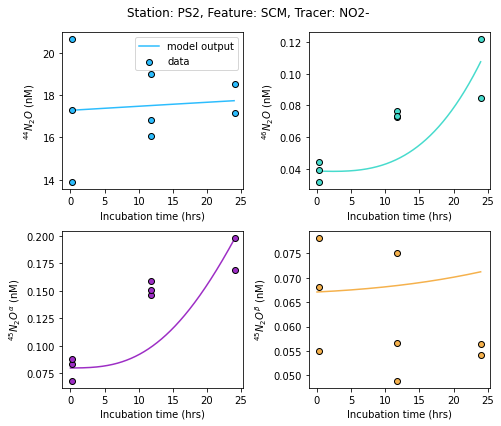

In [116]:
station = "PS2"
feature = "SCM"
tracer = "NO2-"

inputdata=pd.read_csv(f'{sc.datapath()}00_incubationdata.csv')

sc.scatter_plot(data=inputdata, station=station, feature=feature, tracer=tracer,
             modeloutput=output, filename="Figures/PS2SCM15NO2modelv3.pdf")

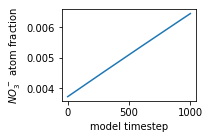

In [113]:
fig, ax = plt.subplots(1,1, figsize = (3,2))

ax.plot(output[['AFNO3-']])
ax.set_xlabel("model timestep")
ax.set_ylabel(r"$NO_3^-$ atom fraction")

plt.tight_layout()
#plt.savefig("figures/no3-atomfraction.pdf")

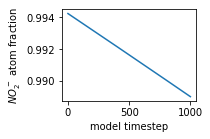

In [114]:
fig, ax = plt.subplots(1,1, figsize = (3,2))

ax.plot(output[['AFNO2-']])
ax.set_xlabel("model timestep")
ax.set_ylabel(r"$NO_2^-$ atom fraction")

plt.tight_layout()
#plt.savefig("figures/no2-atomfraction.pdf")

In [115]:
tracers.no2_15[-1]

array([4649.08363397])

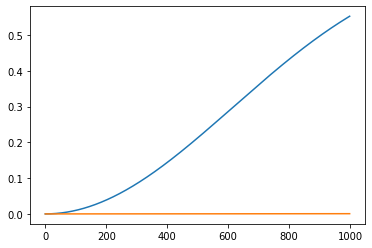

In [116]:
plt.plot(output['hybrid1'])
plt.plot(output['hybrid2'])

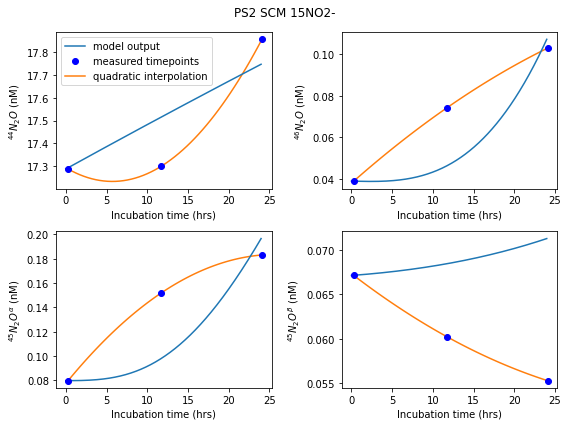

In [117]:
sc.plot_outputs(trainingdata = PS2SCM15NO2, modeloutput=output, 
             filename="Figures/PS2SCM15NO2OLD.pdf")